## Reuters 딥러닝 모델
### 데이터 로드 및 전처리

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

* reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
* 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) # 단어 갯수 10000개로 제한하여 로드

train_data, val_data, train_labels, val_labels = (train_test_split(train_data, train_labels, test_size=0.25))

print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6287
2695
2246
46


* 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행
* 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환

In [3]:
def one_hot_encoding(data, dim=10000):
    matrix = np.zeros((len(data), dim))
    for i, d in enumerate(data) :
        matrix[i, d] = 1.
    return matrix

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

### 모델 구성 및 컴파일
* BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성
* 활성화 함수와 BatchNormalization의 순서를 반대로 하는 것도 고려

In [4]:
model = models.Sequential()
model.add(layers.Dense(32, input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, name='hidden'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dropout(0.2))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 32)                320032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
hidden (Dense)               (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0

### 모델 학습
* ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행

#### ModelCheckpoint
* tf.keras.callbacks.ModelCheckpoint: 정기적으로 모델의 체크포인트를 저장하고, 문제가 발생할 때 복구하는데 사용

* 최상의 모델만을 저장하는 옵션으로 save_best_only=True를 지정

#### EarlyStopping
* tf.keras.callbacks.EarlyStopping: 검증 성능이 한동안 개선되지 않을 경우 학습을 중단할 때 사용
###### 일정 patience 동안 검증 세트에 대한 점수가 오르지 않으면 학습을 정지
###### 모델이 향상되지 않으면 학습이 자동으로 중지되므로, epochs 숫자를 크게 해도 무방
###### 학습이 끝난 후의 최상의 가중치를 복원하기 때문에 모델을 따로 복원할 필요가 없음

In [5]:
check_point_cb = callbacks.ModelCheckpoint('reuter_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                  restore_best_weights=True)
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/40
13/13 [==============================] - 2s 56ms/step - loss: 2.9761 - accuracy: 0.3903 - val_loss: 3.5869 - val_accuracy: 0.5978
Epoch 2/40
13/13 [==============================] - 0s 17ms/step - loss: 2.2365 - accuracy: 0.6060 - val_loss: 3.4190 - val_accuracy: 0.6163
Epoch 3/40
13/13 [==============================] - 0s 17ms/step - loss: 1.8910 - accuracy: 0.6741 - val_loss: 3.2466 - val_accuracy: 0.6245
Epoch 4/40
13/13 [==============================] - 0s 17ms/step - loss: 1.6361 - accuracy: 0.7026 - val_loss: 3.0561 - val_accuracy: 0.6171
Epoch 5/40
13/13 [==============================] - 0s 19ms/step - loss: 1.4384 - accuracy: 0.7231 - val_loss: 2.8825 - val_accuracy: 0.6204
Epoch 6/40
13/13 [==============================] - 0s 16ms/step - loss: 1.2624 - accuracy: 0.7509 - val_loss: 2.6892 - val_accuracy: 0.6408
Epoch 7/40
13/13 [==============================] - 0s 16ms/step - loss: 1.1438 - accuracy: 0.7579 - val_loss: 2.5174 - val_accuracy: 0.6371
Epoch 8/40
13

* 학습 히스토리의 loss, val_loss, accuracy, val_accuracy를 차트로 시각화

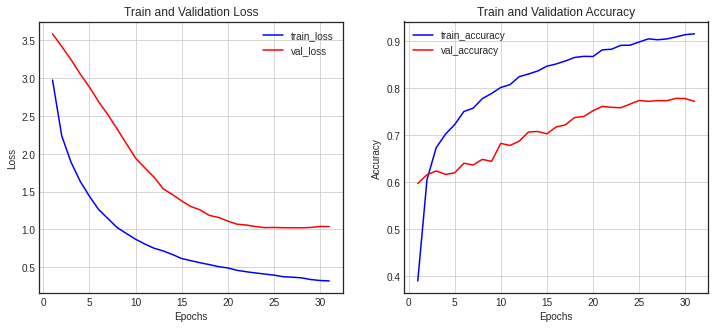

In [6]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측
* 테스트 데이터셋을 이용해 모델을 평가

In [7]:
# 모델 평가 및 예측
test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

pred = model.predict(x_test)
print(pred.shape)
print(pred[0])

71/71 [==============================] - 0s 3ms/step - loss: 1.1074 - accuracy: 0.7645
[1.1073739528656006, 0.7644701600074768]
(2246, 46)
[4.3862063e-04 9.6337555e-04 6.5528182e-04 8.9527774e-01 4.8072774e-02
 5.1627873e-04 2.5382714e-04 4.5034694e-04 1.0670386e-02 3.1888895e-04
 7.0394127e-04 3.1559654e-03 2.4449179e-04 1.5073401e-03 2.0807700e-03
 8.3725940e-04 4.0641553e-03 2.7317617e-03 5.1849167e-04 1.5496304e-03
 2.4443874e-03 1.8017543e-03 6.2993442e-04 5.6703802e-04 3.0549645e-04
 6.9623889e-04 1.1752204e-03 3.4428693e-04 7.8905676e-04 8.4007357e-04
 2.3282270e-04 5.2534498e-04 3.9755655e-03 4.7559969e-04 4.7778839e-04
 2.7681387e-04 2.0651247e-03 8.7643840e-04 4.4934326e-04 1.9188084e-03
 9.1159123e-04 1.5481820e-03 3.4267348e-04 4.1562869e-04 2.2378474e-04
 6.7964150e-04]


### 회고
* 훈련 값과 검증 값의 손실 차이를 일정 이상 줄이기 어려웠다. 
* 테스트 값의 정확도를 0.7 대 이상으로 올리는 것 역시 어려웠다.